## Tutorial for HuggingFace PEFT
在这个文档中，将介绍HuggingFace中PEFT的使用方法。

### 安装PEFT
peft库需要 Python3.8及以上的版本，首次安装时，会同时安装transformers、datasets、torch等等一系列库，所以运行一次安装后Hugging Face的所有功能基本都可以使用了。

In [ ]:
pip install peft

### 选择合适的方法
并非所有方法都适用于各种任务，对于预训练语言模型而言，选择LoRA或者Prefix tuning都是可以的。在HuggingFace的PEFT文档首页，提供了一个网页API，展示所选种类中的model所支持的peft方法，如果你不确定可以使用哪种peft方法，可以在这里快速查到。
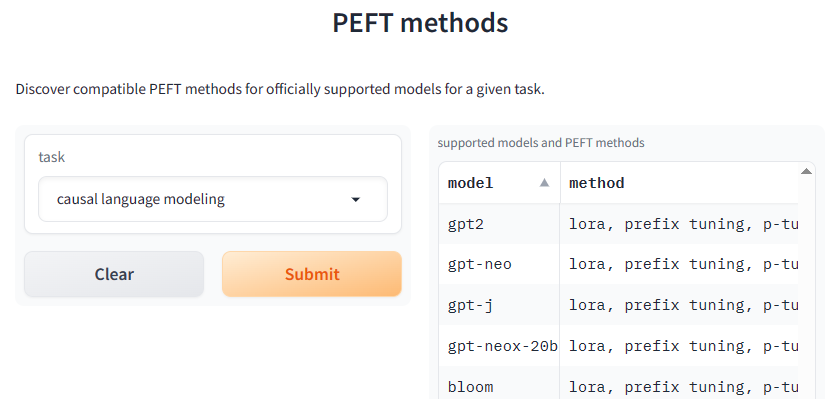

### 前序步骤
在使用model前，你可能需要进行一些设置，加载和处理数据集，对于peft model而言，这些步骤与其它model无异，此处略过。

### 编写配置
peft的各种方法的基本用法相同，只是配置不同，因此后面的部分仅以LoRA为例展示使用。在这一部分中，仅列出LoRA、P-tuning、Prefix tuning、Prompt tuning和IA3这几种主要方法的参数。

**参数说明中列出了所有参数，等号后面的是其默认值，使用时参数大多不用修改**

各种Config类之间的关系如下图，PeftConfig的基类是PeftConfigMixin，但是此处省略。
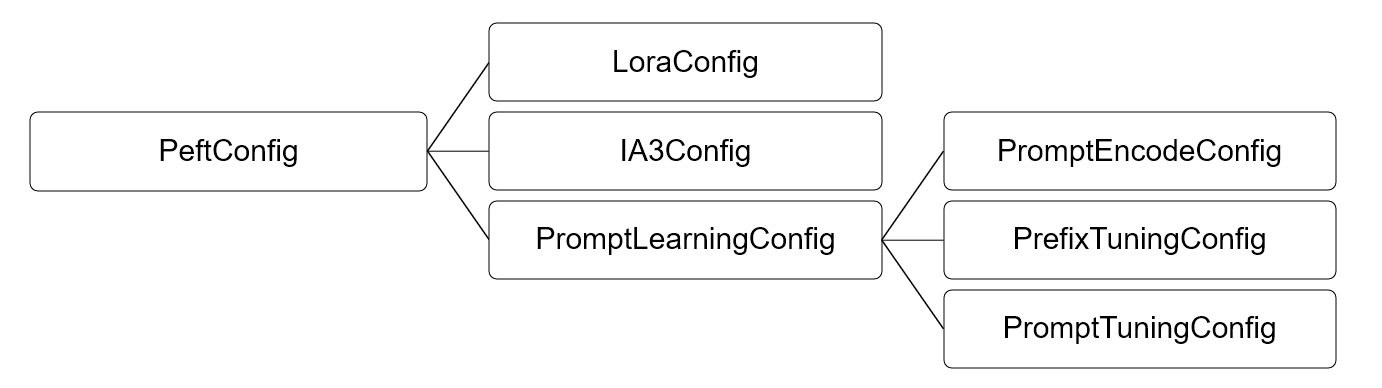

In [ ]:
# PeftType和TaskType，目前版本0.7.1支持的方法和任务类型如下
class PeftType(str, enum.Enum):
    """Enum class for the different types of adapters in PEFT."""

    PROMPT_TUNING = "PROMPT_TUNING"
    MULTITASK_PROMPT_TUNING = "MULTITASK_PROMPT_TUNING"
    P_TUNING = "P_TUNING"
    PREFIX_TUNING = "PREFIX_TUNING"
    LORA = "LORA"
    ADALORA = "ADALORA"
    ADAPTION_PROMPT = "ADAPTION_PROMPT"
    IA3 = "IA3"
    LOHA = "LOHA"
    LOKR = "LOKR"
    OFT = "OFT"

class TaskType(str, enum.Enum):
    """Enum class for the different types of tasks supported by PEFT."""

    SEQ_CLS = "SEQ_CLS"
    SEQ_2_SEQ_LM = "SEQ_2_SEQ_LM"
    CAUSAL_LM = "CAUSAL_LM"
    TOKEN_CLS = "TOKEN_CLS"
    QUESTION_ANS = "QUESTION_ANS"
    FEATURE_EXTRACTION = "FEATURE_EXTRACTION"

In [ ]:
# PeftConfig参数说明
from peft import PeftConfig, PeftType, TaskType

peft_config = PeftConfig{
    peft_type = None, #方法类型，使用PeftType或者字符串，一般不用填
    task_type = None, #任务类型，根据base model的类型填写，使用TaskType或者字符串
    inference_mode= False, #训练时为False，需要推理时设置为True
}

In [ ]:
# LoRA参数说明
from peft import LoraConfig, PeftType, TaskType

lora_config = LoraConfig{
    peft_type = "LORA",
    task_type = None,
    inference_mode = False,
    r = 8, #低秩矩阵的维度，一般4-8即可，太小效果不佳，太大参数过多
    target_modules = None, #要注入LoRA的模块，Transformers一般是["q", "k", "v", "o"]，其它模型按需设置
    lora_alpha = 8, #参数alpha，scale=alpha/r，h=Wx+BAx*scale，scale越大，LoRA矩阵的输出权重越大
    lora_dropout = 0.0, #LoRA layer的dropout率
    fan_in_fan_out = False, #当base model以(fan_in, fan_out)格式存储权重时，需要设置为True
    bias = 'none', #LoRA的Bias类型，‘none’, ‘all’ or ‘lora_only’
    modules_to_save = None, #除LoRA layer外需要训练和保存的模块
    init_lora_weights = True, #LoRA的权重初始化方式，设为False将以完全随机的方式初始化，也可以设为"gaussian", "loftq"
    layers_to_transform = None, #指定layer的索引，设为list或者单个int，通过下标选择target_modules中的模块
    layers_pattern = None, #layer pattern name
    rank_pattern = dict, #r map，可以给不同layer指定不同的r
    alpha_pattern = dict, #alpha map，可以给不同layer指定不同的alpha
    loftq_config = dict, #量化模型使用LoRA方法时设置
}

In [ ]:
# IA3 参数说明
from peft import IA3Config, PeftType, TaskType

ia3_config = IA3Config{
    peft_type = "IA3",
    task_type = None,
    inference_mode = False,
    target_modules = None, #(Union[List[str],str]) — The names of the modules to apply (IA)^3 to.
    feedforward_modules = None, #(Union[List[str],str]) — The names of the modules to be treated as feedforward modules, as in the original paper. These modules will have (IA)^3 vectors multiplied to the input, instead of the output. feedforward_modules must be a name or a subset of names present in target_modules.
    fan_in_fan_out = False, #(bool) — Set this to True if the layer to replace stores weight like (fan_in, fan_out). For example, gpt-2 uses Conv1D which stores weights like (fan_in, fan_out) and hence this should be set to True.
    modules_to_save = None, #(List[str]) — List of modules apart from (IA)^3 layers to be set as trainable and saved in the final checkpoint.
    init_ia3_weights = True, #(bool) — Whether to initialize the vectors in the (IA)^3 layers, defaults to True.
}

In [ ]:
# PromptLearningConfig参数说明
from peft import PromptLearningConfig

pl_config = PromptLearningConfig{
    num_virtual_tokens = None, #(int) — The number of virtual tokens to use.
    token_dim = None, #(int) — The hidden embedding dimension of the base transformer model.
    num_transformer_submodules = None, #(int) — The number of transformer submodules in the base transformer model.
    num_attention_heads = None, #(int) — The number of attention heads in the base transformer model.
    num_layers = None, #(int) — The number of layers in the base transformer model.
}

In [ ]:
# P-tuning参数说明
from peft import PromptEncoderConfig, PeftType, TaskType

p_config = PromptEncoderConfig{
    peft_type = "P_TUNING",
    task_type = None,
    inference_mode = False,
    num_virtual_tokens = None,
    token_dim = None,
    num_transformer_submodules = None,
    num_attention_heads = None,
    num_layers = None,
    encoder_reparameterization_type = PromptEncoderReparameterizationType.MLP , #(Union[PromptEncoderReparameterizationType, str]) — The type of reparameterization to use.
    encoder_hidden_size = None, #(int) — The hidden size of the prompt encoder.
    encoder_num_layers = 2, #(int) — The number of layers of the prompt encoder.
    encoder_dropout = 0, #(float) — The dropout probability of the prompt encoder.
}

In [ ]:
# Prefix tuning参数说明
from peft import PrefixTuningConfig, PeftType, TaskType

prefix_config = PrefixTuningConfig{
    peft_type = "PREFIX_TUNING",
    task_type = None,
    inference_mode = False,
    num_virtual_tokens = None,
    token_dim = None,
    num_transformer_submodules = None,
    num_attention_heads = None,
    num_layers = None,
    encoder_hidden_size = None, #(int) — The hidden size of the prompt encoder.
    prefix_projection = False, #(bool) — Whether to project the prefix embeddings.
}

In [ ]:
# Prompt tuning参数说明
from peft import PromptTuningConfig, PeftType, TaskType

prompt_config = PromptTuningConfig{
    peft_type = "PROMPT_TUNING",
    task_type = None,
    inference_mode = False,
    num_virtual_tokens = None,
    token_dim = None,
    num_transformer_submodules = None,
    num_attention_heads = None,
    num_layers = None,
    prompt_tuning_init = PromptTuningInit.RANDOM, #(Union[PromptTuningInit, str]) — The initialization of the prompt embedding.
    prompt_tuning_init_text = None, #(str, optional) — The text to initialize the prompt embedding. Only used if prompt_tuning_init is TEXT.
    tokenizer_name_or_path = None, #(str, optional) — The name or path of the tokenizer. Only used if prompt_tuning_init is TEXT.
    tokenizer_kwargs = None, #(dict, optional) — The keyword arguments to pass to AutoTokenizer.from_pretrained. Only used if prompt_tuning_init is TEXT.
}

下面给出一个LoraConfig的应用实例

In [ ]:
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    r=16,
    target_modules=["q_proj", "v_proj"],
    task_type=TaskType.CAUSAL_LM,
    lora_alpha=32,
    lora_dropout=0.05
)

### 加载基模型
base model可以是任意的，可以不是Transformers，只是Transformers集成了peft的很多功能，可以省去一些需要自定义的部分，比如target_modules，同时Transformers还支持peft的方法，后面进阶功能中会提及。

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m")

### 创建PEFT模型
通过将base model和config传入get_peft_model()方法，生成一个peft model，该方法内部会根据config中设置的peft type区分使用的peft方法，进入不同的处理流程，最终返回一个处理好的model。

In [ ]:
from peft import get_peft_model

peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()
"trainable params: 1,572,864 || all params: 332,769,280 || trainable%: 0.472659014678278"

在这个例子中，可以通过输出的参数量看到，使用peft进行微调，需训练的参数相比于base model少得多。

### 训练PEFT模型
得到peft model后，其使用方法与一般的模型没有区别，正常地进行训练即可，可以用Transfomers的Trainer、Accelerate，或者用PyTorch自己写一个train loop也可以。

### 保存PEFT模型
训练好的model，可以保存到本地，也可以推送到自己的HuggingFace Hub。

In [ ]:
peft_model.save_pretrained("your-name/opt-350m-lora")

# push to Hub
from huggingface_hub import notebook_login

notebook_login()
peft_model.push_to_hub("your-name/opt-350m-lora")

值得注意的是，peft model在保存时，仅仅保存配置文件和外部权重（各个方法额外增加的那一部分权重），或者说，只保存了adapter。因此，peft model占用的存储空间非常小，这种base model和adapter分别存储的模式，意味着可以用一个base model，针对不同任务，或者同一任务的不同配置训练多个adapter，所需的时间和空间代价很小，同时，可以根据任务需要灵活地使用，需要哪个adapter就注入哪个adapter。
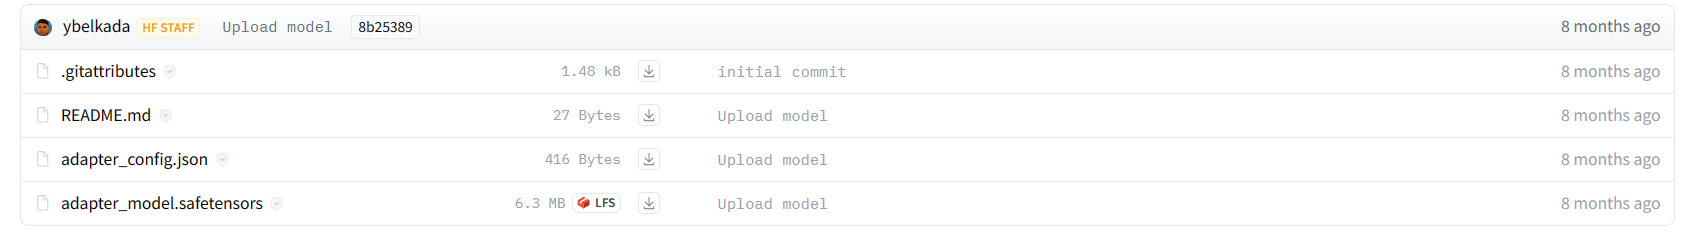
当然，这也意味着无法通过这种方法获得一个完整的模型。如果想要保存一个base model和adapter合并的模型，可以尝试使用后面将要介绍的inject_adapter_in_model()方法。

### 使用PEFT模型
加载peft model并使用有两种方式，一种方式是和创建对称，依次加载config、base model、peft model，这种方式比较灵活，且适用于任意模型；另一种方式是使用AutoPeftModel类，它可以自动完成加载，但是只能用于Transformers中的模型，和AutoModel类是相对应的。

In [ ]:
# 方式1
from peft import PeftModel, PeftConfig

config = PeftConfig.from_pretrained("ybelkada/opt-350m-lora")
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path)
peft_model = PeftModel.from_pretrained(model, "ybelkada/opt-350m-lora")

In [ ]:
# 方式2
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
import torch

model = AutoPeftModelForCausalLM.from_pretrained("ybelkada/opt-350m-lora")

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")
model = model.to("cuda")
model.eval()

### Transformers支持的PEFT功能
在Transformers库中，集成了PEFT的功能，可以使用AutoModel类加载peft model，也可以为一个Transformers中的model注入一个或多个adapter。

**使用add_adapter()时，必须保持peft方法一致，不同方法不能混合**

In [ ]:
# 使用AutoModel加载peft model
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("ybelkada/opt-350m-lora")

In [ ]:
# 注入一个或多个adapter
from transformers import AutoModelForCausalLM
from peft import LoraConfig

model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m")
model.add_adapter(lora_config_1, adapter_name="adapter_1")
model.add_adapter(lora_config_2, adapter_name="adapter_2")

此外，Transformers中还提供了管理adapter的方法。存在多个adapter时，默认启用第一个adapter，可以使用set_adapter()来启用某个或多个adapter。

In [ ]:
# 设置启用的adapter
model.set_adapter("adapter_1")
# 禁用所有adapter
model.disable_adapters()
# 启用adapter
model.enable_adapters()

### 量化模型微调
在这部分，将介绍如何使用PEFT微调量化模型，分别用到了BitsAndBytes和LoftQ两种方法。

In [ ]:
# BitsAndBytes量化
import torch
from transformers import BitsAndBytesConfig, AutoModelForCausalLM
from peft import prepare_model_for_kbit_training

config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1", quantization_config=config)

model = prepare_model_for_kbit_training(model)

In [ ]:
# 使用量化后的模型生成peft model
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=8,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

使用LoftQ初始化LoRA权重，同样可以实现模型量化和微调，且更稳定、表现更好。使用LoftQ时，base model加载时不能被量化。

In [ ]:
from peft import AutoModelForCausalLM, LoftQConfig, LoraConfig, get_peft_model

model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")
loftq_config = LoftQConfig(loftq_bits=4)

lora_config = LoraConfig(
    init_lora_weights="loftq",
    loftq_config=loftq_config,
    r=16,
    lora_alpha=8,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

### 任意模块注入adapter
对于一些用户，可能需要在一些PyTorch Module中注入adapter，但是不依赖peft中的model类别，不用get_peft_model()，此时可以使用peft提供的inject_adapter_in_model()方法完成注入。此方法目前仅可用于LoRA、AdaLoRA和IA3。

In [ ]:
import torch
from peft import inject_adapter_in_model, LoraConfig

class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = self.linear(x)
        x = self.lm_head(x)
        return x

lora_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    target_modules=["linear"],
)

model = DummyModel()
model = inject_adapter_in_model(lora_config, model)

dummy_inputs = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])
dummy_outputs = model(dummy_inputs)

使用这种方法，如果想只保存adapter，可以使用get_peft_model_state_dict()提取adapter的state_dict，但是保存需要自己完成。

In [ ]:
from peft import get_peft_model_state_dict

peft_state_dict = get_peft_model_state_dict(model)
print(peft_state_dict)

### 混合Adapter类型
当你需要使用多个adapter，然而adapter之间差异很大，比如同一种方法但是配置完全不同，或者就是不同方法的adapter时，可以使用PeftMixedModel类实现。

In [ ]:
from peft import PeftMixedModel

base_model = ...  # load the base model, e.g. from transformers
# load first adapter, which will be called "default"
peft_model = PeftMixedModel.from_pretrained(base_model, <path_to_adapter1>)
peft_model.load_adapter(<path_to_adapter2>, adapter_name="other")
peft_model.set_adapter(["default", "other"])

这种混合目前仍是有限制的，能兼容的方法目前只有LoRA、LoHa、LoKr、AdaLoRA和OFT这几种。此外，加载顺序也会影响性能，同类型adapter连续加载一般性能较好。

至此，peft库的使用方法基本介绍完毕，仍有一些零散的功能未介绍到，如果确实需要，可以在熟悉框架结构后去对应的源码中进行探索。